# Assignment 10

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

---

#### ``Objectives``
1. Implement a CNN to detect diabetic retinopathy (DR) from retina images taken using fundus photography under a variety of imaging conditions.
2. Improve generalization performance and reduce overfitting using **image transformation** and **data augmentation** techniques.

#### ``Motivation``

Diabetic retinopathy (DR) is an eye condition that  affects blood vessels in the retina. It can cause vision loss and blindness in people who have diabetes. Screening for DR allows earlier and more effective treatment options for millions of people.

#### ``Data``

In this assignment you will use a small dataset of retina images (`Download` links: [images](https://drive.google.com/drive/folders/1sdfUC64Un1iwuiHEehcbijxB54OhU_nd?usp=sharing) and [labels](https://drive.google.com/drive/folders/1MOlSJBZg7L1HtG5vHPt77ighRvQaGfDg?usp=sharing)). You will **build** and **train** a **CNN model** to predict whether or not to refer a patient for DR treatment using binarized severity of DR in patients: no referral if {No DR, mild} and referral if {moderate, severe, and proliferate DR}.


<u>Note</u>: the original dataset is hosted by Kaggle [[Source]](https://www.kaggle.com/c/aptos2019-blindness-detection/).

Import the necessary libraries and make sure to replace IMAGE_PATH and LABEL_PATH with the path to the directories where you saved the data.

---
### Step 1: Import libraries

In [2]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
IMAGE_PATH = '/Users/mohammedelzubeir/Downloads/DR/CNN_images/' # replace with your path
LABEL_PATH = '/Users/mohammedelzubeir/Downloads/DR/Labels/' # replace with your path

At this point, you may ask yourself what the best model that fits this data is. First, you will want to read through the data description in Kaggle (see the link to the original dataset above). Understanding what you are working with challenges you to write preprocessing code that uncovers your data's most helpful information.

---
#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Read the data description from Kaggle and list (a) the source of images and (b) the labeling procedure.

*Written answer*:

a) The images are collected by technicians who travel rural areas in india and are taken using fundus photography under diverse imaging conditions. They were gathered from a number of clinics using a variety of cameras over an extended period of time, leading to further variation between the images. Images may contain noise such as artifacts, be out of focus or differ in level of exposure.

b) A clinician rates each image on a scale of 0 to 4 where 0 is no diabetic retinopathy (DR), 1 is mild, 2 is moderate, 3 is severe, and 4 is proliferative DR.

---
### Step 2: Data ingestion

Let's load the 2D images and their corresponding labels.

``labels``

In [3]:
labels = pd.read_csv(
    LABEL_PATH + 'labels.csv'
)

print('Shape of labels:', labels.shape)
print('Unique diagnosis codes:', np.sort(labels.diagnosis.unique()))
labels.head()

Shape of labels: (200, 2)
Unique diagnosis codes: [0 1 2 3 4]


,id_code,diagnosis
0,000c1434d8d7,2
1,0024cdab0c1e,1
2,0083ee8054ee,4
3,00a8624548a9,2
4,00b74780d31d,2


There are 200 training images corrresponding to 5 different diabetic retinopathy (DR) diagnosis codes: 

* No DR (0)
* mild (1)
* moderate (2)
* severe (3)
* proliferate DR (4)


``images``

In [4]:
images = []

for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    img = load_img(
    IMAGE_PATH + img)
    images.append(img)

---
### Step 3: Exploratory Data Analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot a histogram for the five classes of DR. Are the classes balanced?


Note: It's acceptable to plot the distribution of classes before splitting your data into training, validation, and test sets. Doing so does not compromise the "blindness" of the test data. Why?

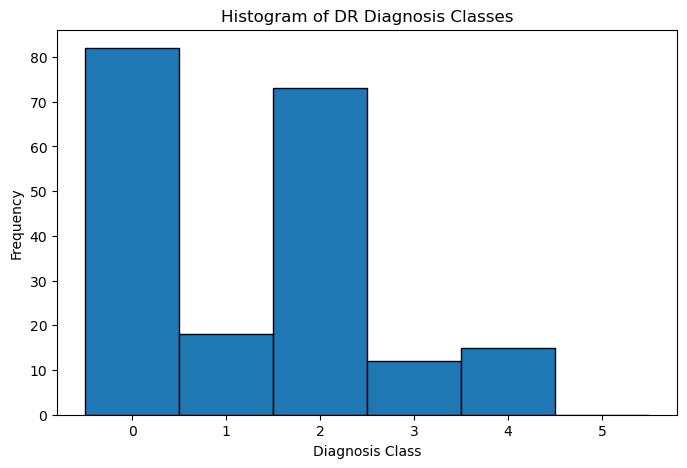

In [5]:
# YOUR CODE HERE
plt.figure(figsize=(8, 5))
n, bins, patches = plt.hist(labels['diagnosis'], bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black', align='mid')

# Set x-ticks at the center of each bin
plt.xticks([0, 1, 2, 3, 4, 5])
plt.title('Histogram of DR Diagnosis Classes')
plt.xlabel('Diagnosis Class')
plt.ylabel('Frequency')
plt.show()

Comment on class balance: The classes are not balanced No DR (0) has over 80 instances, followed by moderate with over 70 instances meanwhile mild (1), severe (3) and proliferate DR (4) all have less than 20 instances each

It's acceptable to plot the distribution of classes before splitting your data into training, validation, and test sets. Doing so does not compromise the "blindness" of the test data because we are merely observing the overall class distribution in the entire dataset without revealing any specific data points or detailed insights from the future test set.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Print 8 images from the data. What can you say about the size, focus/orientation of these images?

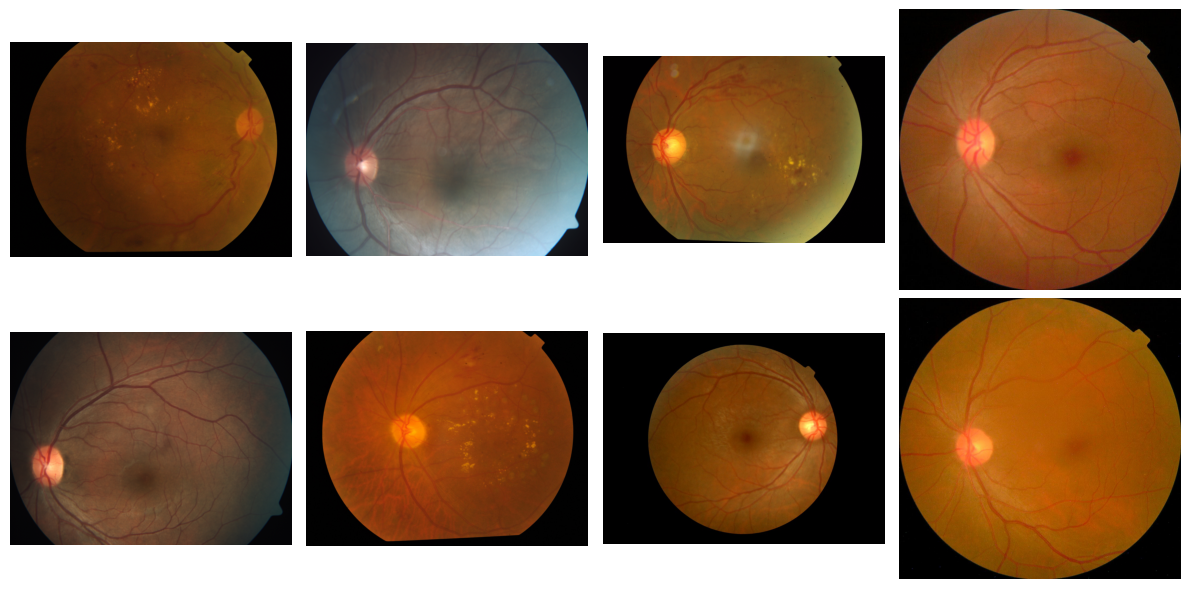

In [6]:
# FILL IN CODE HERE #
# Create a figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(8):
    ax = axes[i]
    ax.imshow(images[i])  # Display the image
    ax.set_axis_off()  # Turn off axis labels for cleaner display

plt.tight_layout()
plt.show()

Comment on the size, focus/orientation of the 8 images: The sizes of the images are not uniform, indicating the dataset has not been preprocessed to standardize image sizes. Their orientations also differ with the 2nd on the first row and 3rd on the 2nd row having the optic disc positioned on the right-hand side with the rest of the images having them positioned on the left-hand side. Most of the images are generally well-focused, showing clear details of the retina, including blood vessels and the optic disc. However, there is one image (top row, second from the left) that appears slightly overexposed or affected by glare, reducing the clarity of its features. This could affect model performance if not accounted for during preprocessing.

---
### Step 4: Data preprocessing

First, we will correct for class imbalance. Note that imbalanced data is common in healthcare, and it happens because some diseases are rare. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We will correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}


  * Second, we'll only take 80 random samples from the 'no refer' class and 80 from the 'refer' class.

It is a crude method to deal with imbalanced data, but it will be good enough for this homework. 

In [7]:
np.random.seed(1234)

no_refer = labels[labels.diagnosis.isin((0,1))]
refer = labels[labels.diagnosis.isin((2,3,4))]

# randomly draw 80 images from each classes
temp_no_refer = list(np.random.choice(
    no_refer.id_code,
    size=80,
    replace=False
))

temp_refer = list(np.random.choice(
    refer.id_code,
    size=80,
    replace=False
))

Next, we will use the ``preprocess_data_part1()`` function defined below to generate lists of images and labels (images_mini and y_mini) based on the values in the temp_no_refer and temp_refer lists. Note that the size of the image is set to (224, 224).

In [8]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    temp_no_refer (str): list of labels for the no refer category
    temp_refer (str): list of labels for the refer category
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp_no_refer and temp_refer selections
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in temp_no_refer:
                y_mini.append(0)
        elif img.split('.')[0] in temp_refer:
                y_mini.append(1)
        else:
            continue

        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(224, 224)
        )
        
        # transform image to array
        img = img_to_array(img)

        # append to images
        images_mini.append(img)

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [9]:
# generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(
    IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer
)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (160, 224, 224, 3)
y_mini shape (160,)


#### <span style="color:chocolate"> Exercise 4 (20 points) </span>

Create train, validation, and test data. Implement the `preprocess_data_part2()` function according to the following guidelines:

1. shuffle images and labels before splitting the data

2. use a (0.6,0.2,0.2)train/validation/test set split

3. perform image transformation and augmentation, as follows:
    * Applied on training set only:
         - create additional copies (augmentations) of the training images by flipping left right each image (Hint: use the method available in the tf.image module).
         - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 192 images and labels.
    * Applied on training, validation, and test sets:
        - rescale images by dividing each pixel by 255.0

Reason for doing image augmentation: The quantity and diversity of data gathered significantly impact the results of a CNN model. One can use augmentations to artificially inflate the training dataset by warping the original data so that their label does not change. These augmentations can significantly improve learning results without collecting new data.

In [10]:
def preprocess_data_part2(images, labels, splits=(0.6, 0.2, 0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    labels (np.ndarray): Labels of shape (N,)   
    splits (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]
    
    # create data splits (training, val, and test sets)
    train_size = int(splits[0] * len(images))
    val_size = int(splits[1] * len(images))
    
    X_train, y_train = images[:train_size], labels[:train_size]
    X_val, y_val = images[train_size:train_size + val_size], labels[train_size:train_size + val_size]
    X_test, y_test = images[train_size + val_size:], labels[train_size + val_size:]
    
    # image augmentation (random flip) on training data
    X_train_augm = tf.image.flip_left_right(X_train)

    # concatenate original X_train and augmented X_train_augm data
    X_train = np.concatenate((X_train, X_train_augm), axis=0)
    y_train_augm = y_train  # Labels remain the same for augmented data
    y_train = np.concatenate((y_train, y_train_augm), axis=0)

    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle).numpy() # transform X back to numpy array instead of tensor
    y_train = tf.gather(y_train, shuffle).numpy() # transform y back to numpy array instead of tensor

    # rescale training, val, and test images by dividing each pixel by 255.0 
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (192, 224, 224, 3)
y_train shape (192,)
X_val shape (32, 224, 224, 3)
y_val shape (32,)
X_test shape (32, 224, 224, 3)
y_test shape (32,)


---
### Step 5: Modeling

#### <span style="color:chocolate"> Exercise 5 (20 points) </span>

The objective is to build and train a CNN model to refer patients to doctors based on the severity of DR seen in these images. You are interested in exploring binary classification of 'no refer' and 'refer'.

Implement a CNN classifier according to the following guidelines (let's call this *model_tf*):

1. Implement this model using the TF Keras API.
1. The model receives input images of size 224 x 224 x 3 (that is, the images have three color channels)
2. The input data goes through one convolutional layer that has the following specifications:
    - filters = 12
    - kernel_size = (4 x 4)
    - strides = (1, 1)
    - padding = 'same'
    - data_format = 'channels_last'
    - name = 'conv_1'
    - activation = 'relu'
3. The convolutional layer is followed by a max-pooling layer with pool_size = (2,2). Note: this will reduce the size of the feature maps.
4. The max-pooling layer is followed by a dropout layer with rate = 0.3.
5. The dropout layer is followed by a flattening layer.
6. The last layer of the model is the classification head.
7. Build and compile the model using the Adam optimizer and learning_rate = 0.1. Print summary of the model.
8. Train the model on (X_train, y_train) data for 20 epochs. Add early stopping (Hint: pass the early_stopping implementation below to the fit() method as "callbacks=[early_stopping]").
9. How many parameters does the model have?
10. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the tf.keras.Model.fit() method returns.
11. Evaluate the accuracy of the model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation datasets. 

In [12]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='accuracy', 
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

/Users/mohammedelzubeir/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 12)   │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       150,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,117 (590.30 KB)

 Trainable params: 151,117 (590.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.5246 - loss: 318.9596 - val_accuracy: 0.9688 - val_loss: 0.2719
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.6507 - loss: 0.6054 - val_accuracy: 0.6562 - val_loss: 0.6780
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.4888 - loss: 0.6946 - val_accuracy: 0.3438 - val_loss: 0.6940
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5112 - loss: 0.6928 - val_accuracy: 0.3438 - val_loss: 0.7110
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5112 - loss: 0.6937 - val_accuracy: 0.3438 - val_loss: 0.7229
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5112 - loss: 0.6952 - val_accuracy: 0.3438 - val_loss: 0.7266
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5112 - loss: 0.6956 - val_accuracy: 0.3438 - val_loss: 0.7239
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


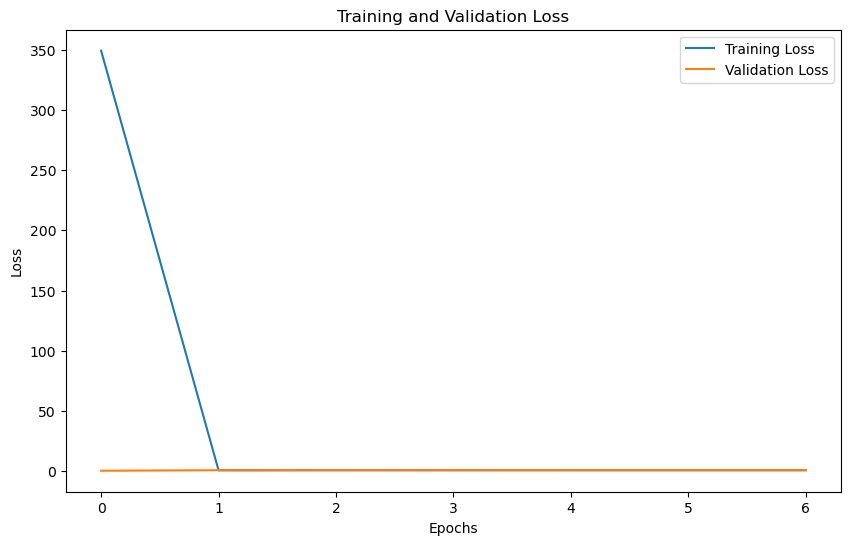

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4187 - loss: 0.7031
Training Accuracy: 0.4688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6562 - loss: 0.6780
Validation Accuracy: 0.6562


In [13]:

tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model_tf = tf.keras.Sequential()

# add convolutional layer
model_tf.add(layers.Conv2D(
    filters=12,
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    activation='relu',
    name='conv_1',
    input_shape=(224, 224, 3)
))

# add max pooling layer 
model_tf.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add dropout layer
model_tf.add(layers.Dropout(rate=0.3))

# add a flattening layer
model_tf.add(layers.Flatten())

# add the classification layer
model_tf.add(layers.Dense(1, activation='sigmoid'))

# build and compile model
model_tf.build(input_shape=(None, 224, 224, 3))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']) 

# print model_tf summary
model_tf.summary()

# train model_tf on (X_train, y_train) data
history = model_tf.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[early_stopping]
)

# plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = model_tf.evaluate(X_train, y_train)
print(f"Training Accuracy: {train_acc:.4f}")

val_loss, val_acc = model_tf.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}")

How many parameters does *model_tf* have? The model has 151,117 parameters, all of which are trainable.

Comment on *model_tf* accuracy on training vs. validation data: Validation accuracy is suprisingly higher than training accuracy, this is likely due to us using early stopping - the model might not have learned enough during training yet - the training set may also be noiser due to the the data augmentation we undertook.

#### <span style="color:chocolate"> Exercise 6 (20 points) </span>

1. Fine-tune the number of hidden layers and the hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various model configurations/hyperparameter values.

2. How many parameters does your fine-tuned model have?

3. Evaluate the accuracy of the fine-tuned model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation datasets.  Is there an improvement compared to the non-fine-tuned version of the model (Exercise 5)?

Model: "fine_tuned_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,946,753 (49.39 MB)

 Trainable params: 12,946,753 (49.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 532ms/step - accuracy: 0.5365 - loss: 0.6883 - val_accuracy: 0.3438 - val_loss: 0.6804
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - accuracy: 0.5961 - loss: 0.6574 - val_accuracy: 0.4062 - val_loss: 0.6436
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 489ms/step - accuracy: 0.6304 - loss: 0.6173 - val_accuracy: 0.8438 - val_loss: 0.5654
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 480ms/step - accuracy: 0.7624 - loss: 0.5559 - val_accuracy: 0.8125 - val_loss: 0.4906
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 477ms/step - accuracy: 0.7908 - loss: 0.5065 - val_accuracy: 0.8125 - val_loss: 0.4373
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 474ms/step - accuracy: 0.8471 - loss: 0.4517 - val_accuracy: 0.9375 - val_loss: 0.3576
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - accuracy: 0.8650 - loss: 0.4302 - val_accuracy: 0.9375 - val_loss: 0.2938
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step - accuracy: 0.8767 - loss: 0.3757 - val_accuracy: 0.9688 - val_loss:

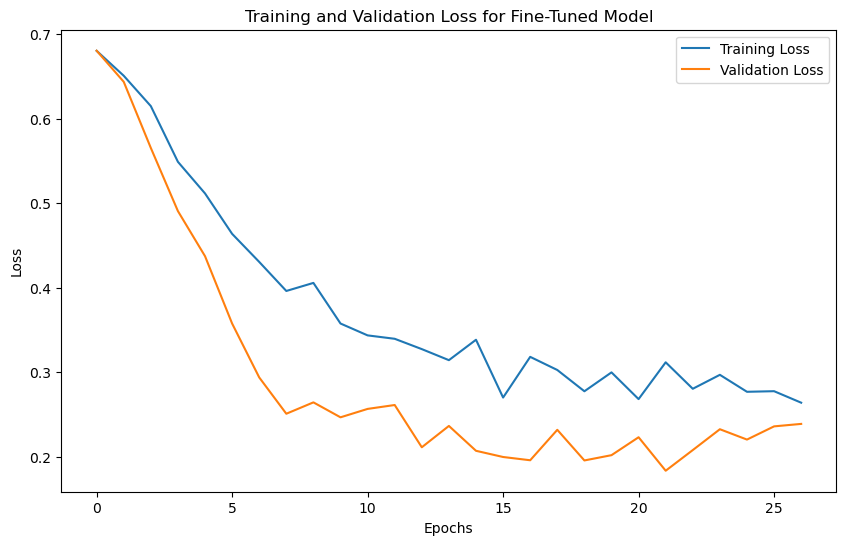

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9041 - loss: 0.2830
Training Accuracy: 0.9115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9062 - loss: 0.1834
Validation Accuracy: 0.9062


In [20]:

# Set random seed for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Define a function to build a fine-tuned model
def build_fine_tuned_model():
    model = models.Sequential(name='fine_tuned_model')
    
    # Add input layer
    model.add(layers.InputLayer(input_shape=(224, 224, 3), name='input'))
    
    # Add multiple convolutional and pooling layers for fine-tuning
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_1'))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_2'))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_3'))
    
    # Add dropout layer to prevent overfitting
    model.add(layers.Dropout(rate=0.4, name='dropout_1'))
    
    # Flatten the output for the dense layers
    model.add(layers.Flatten(name='flatten'))
    
    # Add dense layers for deeper learning
    model.add(layers.Dense(128, activation='relu', name='dense_128'))
    model.add(layers.Dropout(rate=0.4, name='dropout_2'))
    model.add(layers.Dense(64, activation='relu', name='dense_64'))
    
    # Add the final classification layer
    model.add(layers.Dense(1, activation='sigmoid', name='output'))
    
    # Compile the model with a reduced learning rate for fine-tuning
    model.compile(optimizer=optimizers.Adam(learning_rate=0.00005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Build and compile the fine-tuned model
fine_tuned_model = build_fine_tuned_model()

# Print model summary to check the number of parameters
fine_tuned_model.summary()

# Define early stopping callback to monitor validation loss
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Train the fine-tuned model
history = fine_tuned_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Use more epochs to observe potential improvements
    callbacks=[early_stopping]
)

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for Fine-Tuned Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on training and validation sets
train_loss, train_acc = fine_tuned_model.evaluate(X_train, y_train)
print(f"Training Accuracy: {train_acc:.4f}")

val_loss, val_acc = fine_tuned_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}")


How many parameters does your fine-tuned model have? The model has 12,946,753 parameters, all of which are trainable

Comment on accuracy of the fine-tuned model on training vs. validation performance. Is there an improvement over the non-fine-tuned version? There is a large improvement over the non-fine-tuned version. Currently accuracy is 90.41% on training and 90.62% on validation which is an improvement over 46.88% and 65.62% respectivelty.

---
### Step 6: Evaluation

#### <span style="color:chocolate"> Exercise 7 (10 points) </span>

You will now use the test data to evaluate the performance (accuracy) of your fine-tuned model on unseen data. Does your model generalize well?

In [21]:
### YOUR CODE HERE ###

test_loss, test_acc = fine_tuned_model.evaluate(X_test, y_test)

# Print the test accuracy
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6875 - loss: 0.5887
Test Accuracy: 0.6875
Test Loss: 0.5887


Does your model generalize well? The model does not generalize well, currently test accuracy is 68.75% which is much lower than validation accuracy of 90.62%. It's performance on the test set is still better than a coin toss so the model is somewhat useful on unseen data